# Scraping OpenLearn

In previous years, OpenLearn used to publish an OPML feed that list all the units available on OpenLearn. The feed included the unit name, the module code for the original OU module from which the OpenLearn unit was derived, and a link to unit homepage on OpenLearn.

That feed is no longer available, but a single HTML page listing all the free units is still available at https://www.open.edu/openlearn/free-courses/full-catalogue

![Screenshot of OpenLearn full unit catalogue](images/openlearn_units.png)

The units are listed within an HTML table, one unit per row, with the following structure:

```html
<table>
    ...
    <tr class="even">
        <td class="views-field views-field-title active views-align-left title"
            data-sort-value="visions of protest: graffiti">
            <a href="https://www.open.edu/openlearn/history-the-arts/visions-protest-graffiti/content-section-0">Visions of protest: graffiti</a>
            <span class="hidden"> Y031</span>
        </td>
        <td class="views-field views-field-field-ou-course views-align-center
                   field_ou-course" data-sort-value="Y031">
            Y031
        </td>
        <td class="views-field views-field-field-duration views-align-center field_duration"
            data-sort-value="8">
            8
        </td>
        <td class="views-field views-field-field-educational-level views-align-left field_educational_level"
            data-sort-value="Introductory">
            Introductory
        </td>
    </tr>
    ...
</table>
```

<!--
![Raw HTML for a single unit listing on OpenLearn full catalogue](images/openlearn_unit_html.png)
-->

## Scraping the List of Free OpenLearn Units

From the HTML table that lists all the free units available on OpenLearn, we can grab a list of the unit names, duration, level, original OU module and the OpenLearn unit URL.

We can also generate candidate URLs for the OU-XML and HTML zip downloads. These URLs are conventionally defined, but the resources are not necessarily published there. Having generated the URL, we can make a simple HTTP/HEAD request to see whether a resource is actually available at the URL (if the resource is available, we get a 200/OK message; if the resource is not available, we get a 404/Page not found).

In [1]:
# The requests package provides a range of utilities for
# making http calls, retrieving html pages etc
import requests

# If appropriate, we can cache http requests made using the requests package
import requests_cache
requests_cache.install_cache('openlearn_cache')
# Suspend with with requests_cache.disabled():

# The BeuatifulSoup package provides a range of tools for parsing
# HTML documents and scraping elements from them
from bs4 import BeautifulSoup

# We can use the tqdm package to provide progress bar indicators
# that allow us to keep track of the state of progress of a scrape
# of multiple pages
from tqdm.notebook import tqdm

Our scrape begins by grabbing the HTML page for the free unit catalogue and extracting the table that contains the unit listings:

In [2]:
# URL for the OpenLearn full catalogue of free units
srcUrl='https://www.open.edu/openlearn/free-courses/full-catalogue'

# Grab the HTML page
html = requests.get(srcUrl).content
  
# Creating a soup object (a navigable tree element)
soup = BeautifulSoup(html, 'html.parser')

# The table containing the listing is found within a div element
# with a particular, unique id
table = soup.find("div", {"id": "expander_content_11"}).find("table")

For each row in the table, except from the header row, we can extract the OpenLearn unit name and homepage URL, and the level, anticipated duration, and parent OU module code, if available. We can also derive conventional URLs for the OU-XML and HTML zip downloads, and make HTTP/HEAD requests to poll to see whether those assets actually exist at the conventional location. 

In [3]:
# We're going to build up a list of dicts, one dict per unit
units = []

# The first row of the table is a header row
# so we can skip it
for row in tqdm(table.find_all("tr")[1:]):
    
    # Get the url for each OpenLearn unit homepage
    url = xmlurl = htmlurl = row.find("a").get("href")
    
    # Get the unit name, parent OU module code, level and time allocation
    name = row.find("a").text.strip()
    code = row.find("span", {"class":"hidden"}).text.strip()
    level = row.find("tx", {"class":"field_educational_level"})
    duration = row.find("td", {"class":"field_duration"})

    # Simple cleaning
    level = level.text.strip() if level else level
    duration = duration.text.strip() if duration else duration
    
    # Do a simple header check to see if the ou-xml and html downloads
    # are available at the conventional location
    # We could look at the full homepage for download element links
    # but that means actually loading each unit page, rather than just
    # performing a header check
    for stub in ["content-section-overview", "content-section-0" ]:
        xmlurl = xmlurl.replace(stub, "altformat-ouxml")
        htmlurl = htmlurl.replace(stub, "altformat-html")

    xmlurl = xmlurl if "altformat-ouxml" in xmlurl and requests.head(xmlurl).status_code==200 else None
    htmlurl = htmlurl if "altformat-html" in htmlurl and requests.head(htmlurl).status_code==200 else None

    # Build up a list of dicts, one dict per unit on OpenLearn
    units.append({"name": name, 
                  "url": url,
                  "code": code,
                  "level": level,
                  "duration": int(duration),
                  "xmlurl": xmlurl,
                  "htmlurl": htmlurl
                 }
                )

  0%|          | 0/432 [00:00<?, ?it/s]

Preview the results of the scrape:

In [4]:
units[:3]

[{'name': 'A brief history of communication: hieroglyphics to emojis',
  'url': 'https://www.open.edu/openlearn/languages/a-brief-history-communication-hieroglyphics-emojis/content-section-0',
  'code': 'L101',
  'level': None,
  'duration': 5,
  'xmlurl': 'https://www.open.edu/openlearn/languages/a-brief-history-communication-hieroglyphics-emojis/altformat-ouxml',
  'htmlurl': 'https://www.open.edu/openlearn/languages/a-brief-history-communication-hieroglyphics-emojis/altformat-html'},
 {'name': 'Academi Arian MSE',
  'url': 'https://www.open.edu/openlearn/money-business/academi-arian-mse/content-section-overview',
  'code': '',
  'level': None,
  'duration': 12,
  'xmlurl': None,
  'htmlurl': None},
 {'name': 'Accessibility of eLearning',
  'url': 'https://www.open.edu/openlearn/education-development/education-careers/accessibility-elearning/content-section-0',
  'code': 'H807',
  'level': None,
  'duration': 15,
  'xmlurl': 'https://www.open.edu/openlearn/education-development/educa

We can add the list of units to a simple database table using the file based SQLite database.

In [5]:
# The sqlite_utils package provides a wide range of tools
# that support working with SQLite databases
from sqlite_utils import Database

# The database will be saved to a file
dbname = "all_openlean_xml.db"

# If necessary, provide a clean start
#!rm -f $dbname

# Create a database connection
# This creates the database file if it does not already exist
# otherwise we connect to a pre-existing database file
db = Database(dbname)

We can create a database table structure on the fly simply by inserting documents into it, or we can create a database table schema in advance. We can also create a secondary table that supports free text search and that will be dynamically updated whenever we add a record to the table we want to provide free text search over.

In [6]:
# Create a new table reference (units)
all_units = db["units"]

# Clear the table to give us a fresh start
# Setting ignore=True prevents an error if the table does not exist
all_units.drop(ignore=True)

# Define the table structure
all_units.create({
    "code": int,
    "name": str,
    "level": str,
    "duration": int,
    "url": str,
    "xmlurl": str,
    "htmlurl": str
}, pk=("code","name"))
# The name of the OpenLearn unit and the parent OU module code
# should be a unique combination, which means we can use them
# as a primary key for the table

# We can improve search over the table by supporting free text search.
# This involves the creation of a secondary table with a free text search 
# index provided over one or more specified columns.
# The free text search table is automatically updated whenever one or more
# items are added to the table with which the search index is associated.
db[f"{all_units.name}_fts"].drop(ignore=True)
all_units.enable_fts(["name", "code"], create_triggers=True)

<Table units (code, name, level, duration, url, xmlurl, htmlurl)>

We can now add our list of units to the `units` table in the database (the free text search table will be automatically updated):

In [7]:
all_units.insert_all(units)

<Table units (code, name, level, duration, url, xmlurl, htmlurl)>

Let's try a test query, pulling the results back into a `pandas` dataframe for convenience:

In [8]:
import pandas as pd

pd.read_sql("SELECT * FROM units LIMIT 3", con=db.conn)

,code,name,level,duration,url,xmlurl,htmlurl
0,L101,A brief history of communication: hieroglyphic...,None,5,https://www.open.edu/openlearn/languages/a-bri...,https://www.open.edu/openlearn/languages/a-bri...,https://www.open.edu/openlearn/languages/a-bri...
1,,Academi Arian MSE,None,12,https://www.open.edu/openlearn/money-business/...,None,None
2,H807,Accessibility of eLearning,None,15,https://www.open.edu/openlearn/education-devel...,https://www.open.edu/openlearn/education-devel...,https://www.open.edu/openlearn/education-devel...


We can also try a free text search:

In [9]:
# free text search term(s)
# This may include boolean search operators
q = "history communication OR H807"


# Construct a query onto the free text search index
_q = f"""
SELECT * FROM units_fts WHERE units_fts MATCH {db.quote(q)} ;
"""

pd.read_sql(_q, con=db.conn)

,name,code
0,A brief history of communication: hieroglyphic...,L101
1,Accessibility of eLearning,H807


## Building a Database of OU-XML Documents

From the list of free units on OpenLearn, we constructed the URL for the OU-XML download associated with the unit and polled the OpenLearn website to check whether the resource exisited. Only OU-XML URLs that refer to an actually downloadable resource were then added to our units list, and to the database.

We can now create a futher table into which we will insert the OU-XML document (where available) associated with each OpenLearn unit.

*If the `units` list is not available, we could query the `units` database table for units where the OU-XML URL exists, and then use that list to download the referenced OU-XML resources and add them to our database.

In [10]:
all_xml_tbl = db["xml"]
all_xml_tbl.drop(ignore=True)

all_xml_tbl.create({
    "code": int,
    "name": str,
    "xml": str
}, pk=("code", "name"), if_not_exists=True)

<Table xml (code, name, xml)>

Let's grab all the files, again using a `tqdm` progress bar to help us keep track of how much progress we have made.

*To optimise things a little, only try to grab units where we know there is an OU-XML resource available.*

In [11]:
# The following construction is know as a list comprehension
# We construct a new list from the units list containing only
# units where the OU-XML url (u["xmlurl"]) exists
_units = [u for u in units if u["xmlurl"]]

# For each unit with an ouxml URL, get the OU-XML resource
# and add it to the database
for u in tqdm( _units ):
    all_xml_tbl.insert({"code": u["code"],
                        "name":u["name"],
                        "xml": requests.get(u["xmlurl"]).content})

  0%|          | 0/400 [00:00<?, ?it/s]

Let's preview what we've got:

In [12]:
pd.read_sql("SELECT * FROM xml LIMIT 3", con=db.conn)

,code,name,xml
0,L101,A brief history of communication: hieroglyphic...,"b'<?xml version=""1.0"" encoding=""utf-8""?>\n<?sc..."
1,H807,Accessibility of eLearning,"b'<?xml version=""1.0"" encoding=""utf-8""?>\n<?sc..."
2,,Addysg gynhwysol: deall yr hyn a olygwn (Cymru),"b'<?xml version=""1.0"" encoding=""UTF-8""?>\n<Ite..."


### Retrieving and Working With OU-XML Stored in the Database

We can now grab an OU-XML document from our database, parse it into an XML object:

In [13]:
from lxml import etree
# Grab the XML from the atabase for a particular module
# (If there are several units derived from the module,
# use the first in the results list)
h807_xml_raw = pd.read_sql("SELECT xml FROM xml WHERE code='H807'", con=db.conn).loc[0, "xml"]

# Parse the XML into an xml object
root = etree.fromstring(h807_xml_raw)

root

<Element Item at 0x7fc64eb09680>

We can now run a simple XPATH query directly over the parsed XML object:

In [14]:
# Use xpath expressions to navigate to particular elements
# in the XML document object
# Select the first ItemTitle element and render its text content
root.xpath("ItemTitle")[0].text

'Accessibility of eLearning'

We can also query deeper into the document, and render the structure of a particular element. The following convenience function will return the raw XML in binary or string form associated with a particular XML document node element: 

In [15]:
def unpack(x, as_str=False):
    """Convenience function to look at the structure of an XML object."""
    return etree.tostring(x) if not as_str else etree.tostring(x).decode()

Let's see what we get if we view the `<LearningOutomes>` element:

In [16]:
print( unpack( root.xpath("//LearningOutcomes")[0], as_str=True))

<LearningOutcomes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
                                                  <Paragraph>After studying this course, you should be able to:</Paragraph>
                                                  <LearningOutcome>discuss the main challenges facing disabled students with respect to eLearning.</LearningOutcome>
                                                  <LearningOutcome>have an understanding of the types of technology used by disabled students.</LearningOutcome>
                                                  <LearningOutcome>consider what adjustments you might make in creating eLearning materials to ensure they are accessible and usable.</LearningOutcome>
                                                  <LearningOutcome>consider appropriate ways to evaluate the accessibility and usability of your eLearning materials. </LearningOutcome>
                                        </LearningOutcomes>
                                

## Scraping and Storing HTML Media Assets

The easiest way to grab the media assets associated with each unit is probably to download the HTML bundle.

To be most useful, this means we need to be able to reconcile the downloaded assets with the media assets referenced in the corresponding OU-XML document.

Rather than download all the media assets for all the free OpenLearn units, we will limit ourselves to a simple proof of concept that just downloads the assets associated with a single OpenLearn model.

We will leave the question of how to reconcile the assets with the assets referenced in the corresponding OU-XML document till another time. However, we will show how we can work with downloaded media assets that have been saved into our database.

To start with, let's find a unit for which we have an  

In [17]:
# Get the list of units where there's an html URL and take the first
# We could of course also query our database to fin one...
example_unit = [u for u in units if u["htmlurl"]][0]

example_unit

{'name': 'A brief history of communication: hieroglyphics to emojis',
 'url': 'https://www.open.edu/openlearn/languages/a-brief-history-communication-hieroglyphics-emojis/content-section-0',
 'code': 'L101',
 'level': None,
 'duration': 5,
 'xmlurl': 'https://www.open.edu/openlearn/languages/a-brief-history-communication-hieroglyphics-emojis/altformat-ouxml',
 'htmlurl': 'https://www.open.edu/openlearn/languages/a-brief-history-communication-hieroglyphics-emojis/altformat-html'}

Let's get the HTML bundle URL, an also extract the unit path name; we can use the latter to name our download file.

In [18]:
# Get the HTML bundle download URL
hurl = example_unit["htmlurl"]

#Get the pathname for the unit
fname = hurl.split('/')[-2]

#Preview these variables
print(f"- hurl: {hurl}\n- fname: {fname}")

- hurl: https://www.open.edu/openlearn/languages/a-brief-history-communication-hieroglyphics-emojis/altformat-html
- fname: a-brief-history-communication-hieroglyphics-emojis


The HTML is is actually a zip file. We can use the `urllib.request` to download this package to our computer.

In [19]:
import urllib.request

# Create a helper to download the resource for us
getter = urllib.request.URLopener()

# Specify a name for the downloaded file
download_file = f"{fname}.zip"

getter.retrieve(hurl, download_file)

# This is the file we saved the resource as
download_file

'a-brief-history-communication-hieroglyphics-emojis.zip'

We can peek inside the zip archive file using the `zipfile` package:

In [20]:
import zipfile

# zip file handler  
zip_ = zipfile.ZipFile( download_file )

# list available files in the container
zip_.namelist()[30:50]

['Items/x_7_l101_1_4.html',
 'Items/x_8_l101_1_4_1.html',
 'Items/x_9_l101_1_4_2.html',
 'Items/x_l101_1__descriptiond0e321.html',
 'Items/x_l101_1__descriptiond0e373.html',
 'Items/x_l101_1__descriptiond0e400.html',
 'Items/x_l101_1__descriptiond0e425.html',
 'Items/x_l101_1__descriptiond0e618.html',
 'Items/x_l101_1__descriptiond0e689.html',
 'Items/x_l101_1__descriptiond0e868.html',
 'Items/x_l101_1__transcriptd0e281.html',
 'Items/x_l101_1__transcriptd0e713.html',
 'Items/_31fc26135690af3deb1715277799629474e0d87f_l101_2018j_aug037.mp3',
 'Items/_36eab0b10aa000c0eb95f4e1477d160bc385d5ce_l101_ol_twitter_emoji.mp4',
 'Items/_7230df23b5f8f3060b83c6e99739622f8735350b_l101_ol_218698sumeriancuneiformtabletfig4.tif',
 'Items/_81f1f0e2202e38db69792d8252d6dc827058f631_l101_ol186633_fig1emoji_decorative.tif',
 'Items/_8a6712fa3ab54067a8165ef97c01bebf9d504e1d_l101_ol_figure9.jpg',
 'Items/_9869fc8aa3ffbb0c5ceeceaaeeac7a7a1acf6877_l101_blk1_u4_pt3.eps.jpg',
 'Items/_b735beaea648bb1268b74b8b7987

The zip file is organised like a directory: it contains files and subdirectories within it.

The OU-XML content has been rendered into separate HTML files for the different XML sections (for example, `Items/x_7_l101_1_4.html`). There also seem to be lots of images in the zipfile, not all of which may be "content" images (for example, some images may be logos or navigation icons).

One way of finding out which images are content related is to look through the content HTML documents and extract the image references from them.

The following function takes the path to a downloaded zip file, looks inside it for "contentful" HTML pages, and then attempts to find references to "contentful" figure images.

*Note that the HTML bundles for different units may have been generated at different times and may have different internal HTML structure.*

In [21]:
def get_imgs_from_html(zip_, zip_fpath):
    """Get a list of image paths and alt text from an HTML file."""
    
    # Open zip file
    f = zip_.open(zip_fpath)
    
    # Create a reference to an HTML parser
    soup = BeautifulSoup(f, 'html.parser')
    
    # Depending on when the HTML bundle was generated,
    # we often find image references in a particularly classed
    # div element
    figures = soup.find_all("div", {"class": "oucontent-figure"})
    
    fig_list = []
    # For each figure reference
    for fig in figures:
        # Get the local image path
        # This path is locally valid in the zipfile context
        img_path = fig.find("img").get('src')
        fig_list.append(img_path)

    return fig_list

If we iterate through what we assume to be the contentful HTML files, we can get a list of references to what we assume are contentful images:

In [22]:
# A list of what we assume to be "contentful images"
images = []

# Get a reference to the zip file
zip_ = zipfile.ZipFile( download_file )

# Iterate through the directories and files in the zip file
# Note that we consume the list as we iterate it,
# so if we want to view the list again we need to recreate
# the zip_ reference
for n in zip_.namelist():
    # Assume a "contentful" html file is one on the Items/ path
    if n.startswith("Items/") and n.endswith(".html"):
        # Grab the image references from the file on that path
        _images = get_imgs_from_html(zip_, n)
        # Add the list of images from that file to our overall
        # list of contentful images
        images.extend(_images)

images

['_8a6712fa3ab54067a8165ef97c01bebf9d504e1d_l101_ol_figure9.jpg',
 '_ddd79f44c1411de8c1f9689825f45189df1c11f3_l101_fig1_186141gedoenmaheux.jpg',
 '_9869fc8aa3ffbb0c5ceeceaaeeac7a7a1acf6877_l101_blk1_u4_pt3.eps.jpg',
 '_81f1f0e2202e38db69792d8252d6dc827058f631_l101_ol186633_fig1emoji_decorative.tif',
 '_d7b7906d25a1744b217da0673439d17c601eb728_l101_fig2_218416hieroglyphics.tif',
 '_b735beaea648bb1268b74b8b7987f20ae3c0054d_l101_ol_fig3_218696_lascaux_cave_paintings.jpg',
 '_7230df23b5f8f3060b83c6e99739622f8735350b_l101_ol_218698sumeriancuneiformtabletfig4.tif']

If required, we can open and preview the image files directly from the zip file:

In [23]:
# extract a specific file from the zip container
# Let's grab one of the images
image_file = zip_.open(f"Items/{images[0]}")
image_file

<zipfile.ZipExtFile name='Items/_8a6712fa3ab54067a8165ef97c01bebf9d504e1d_l101_ol_figure9.jpg' mode='r' compress_type=deflate>

As this is actually an image file, we can preview it using the `Pillow` package:

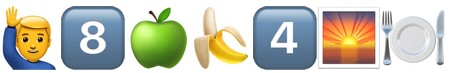

In [24]:
#%pip install Pillow
from PIL import Image

Image.open(image_file)

### Adding Images to a Database

As a proof of concept, let's see how we might add some images to out database, and then retrieve them again.

In [25]:
# Create a test database
# Give ourselves a clean slate to work with
test_db_name = "image_test.db"
!rm -f $test_db_name
db_test = Database(test_db_name)

# Create a test table in that database
db_test_table = db_test["test_table"]

# Add an image directly to that table
# An appropriate table schema will be created automatically
# Get a reference to an image file
image_file = zip_.open(f"Items/{images[0]}")

# Read the contents of the file
image_data = image_file.read()

# and add inage data to the database
db_test_table.insert({"item": image_data})

<Table test_table (item)>

We can preview the schema created for the table:

In [26]:
db_test_table.schema

'CREATE TABLE [test_table] (\n   [item] BLOB\n)'

*If we were to create our own table definition, we would set the column type to `"BLOB"`.*

We can see the image data is now in our database:

In [27]:
pd.read_sql("SELECT * FROM test_table", con=db_test.conn)

,item
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01...


We can also read the data out and re-display the image:

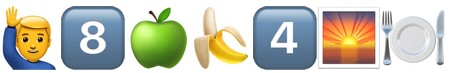

In [28]:
import io

#Get the image data
img_data = pd.read_sql("SELECT * FROM test_table", con=db_test.conn).loc[0, "item"]

# To "open" the image using Image.open()
# we need to make an appropriate virtual file object
img_data_s = io.BytesIO(img_data)

# "Open" the virtual image file
Image.open(img_data_s)

We can also render the image data directly using the IPython.display.Image` machinery:

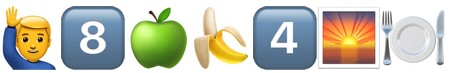

In [29]:
from IPython.display import Image as Image2

Image2(img_data)

## Summary

In this section, we have seen how we can scrape a list of free OpenLearn units from a catalogue web page on the OpenLearn website and add this data to a simple, file-based database that supported free text search over the OpenLearn unit name and OU module code.

We also saw how we could generate conventional URL paths that allowed us to download the OU-XML files associated with free OpenLearn units and add those to a database table. The XML can then be retrieved from the database and represented as an XML object that can be queried using XPATH expressions.

Finally, we demonstrated how we can download an HTML bundle associated with an OpenLearn unit as a zip archive file and programmatically inspect its contents. From the assumed "contentful" HTML files in the archive we could identify assumed "contentful" images, extract them from the archive file, preview them, store them in a simple file based database, retrieve them from the database and preview them again.